QCBM implementation in Pennylane to identify differences in simulators


In [55]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)


class MMD:

    def __init__(self, scales, space):
        gammas = 1 / (2 * (scales**2))
        sq_dists = jnp.abs(space[:, None] - space[None, :]) ** 2
        self.K = sum(jnp.exp(-gamma * sq_dists) for gamma in gammas) / len(scales)
        self.scales = scales

    def k_expval(self, px, py):
        # Kernel expectation value
        return px @ self.K @ py

    def __call__(self, px, py):
        pxy = px - py
        return self.k_expval(pxy, pxy)

In [56]:
from functools import partial


class QCBM:

    def __init__(self, circ, mmd, py):
        self.circ = circ
        self.mmd = mmd
        self.py = py  # target distribution π(x)

    @partial(jax.jit, static_argnums=0)
    def mmd_loss(self, params):
        px = self.circ(params)
        return self.mmd(px, self.py), px

In [57]:
import pennylane as qml

np.random.seed(42)


n_qubits = size
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 6
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)


@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(weights=weights, ranges=[1] * n_layers, wires=range(n_qubits))
    return qml.probs()


jit_circuit = jax.jit(circuit)

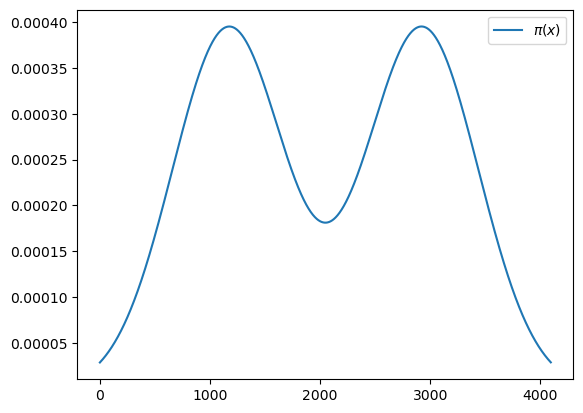

[2.89053154e-05 2.90345903e-05 2.91643321e-05 ... 2.92962355e-05
 2.91660182e-05 2.90362689e-05]


In [58]:
def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)


n_qubits = 12
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(2 / 7) * x_max, (5 / 7) * x_max]
sigmas = [x_max / 8] * 2
ndata = mixture_gaussian_pdf(x_input, mus, sigmas)

plt.plot(ndata, label=r"$\pi(x)$")
plt.legend()
plt.show()

print(ndata)

In [59]:
import os
import pandas as pd 

print(os.getcwd())
data = pd.read_csv('grad_data_2023.csv')
data_22 = data[data['trade_date'] == "2023-05-22"]
data_23 = data[data['trade_date'] == "2023-05-23"]




feature = "delta"
data.head()


/home/sohamd/Quantum-Deep-Hedging/src/testing/QCBM


,theo_event_tx_timestamp,trade_date,option_type_name,term,strike,tv,delta,gamma,under,tte,vega
0,2023-05-22 11:55:02.407195,2023-05-22,PUT,Jun-2023,26.22,0.987344,-0.538346,0.191068,25.800806,0.075243,2.810530
1,2023-05-22 12:00:15.409357,2023-05-22,PUT,Jun-2023,26.22,0.987280,-0.538348,0.191084,25.800806,0.075232,2.810316
2,2023-05-22 12:01:17.787593,2023-05-22,PUT,Jun-2023,26.22,0.987276,-0.538348,0.191085,25.800806,0.075231,2.810300
3,2023-05-22 12:15:15.408862,2023-05-22,PUT,Jun-2023,26.22,0.987216,-0.538350,0.191099,25.800806,0.075220,2.810101
4,2023-05-22 12:30:15.408916,2023-05-22,PUT,Jun-2023,26.22,0.987153,-0.538352,0.191115,25.800806,0.075209,2.809887


<Axes: >

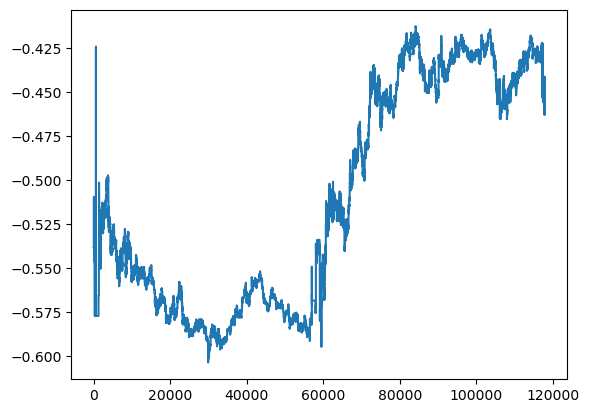

In [60]:
data[feature].plot()

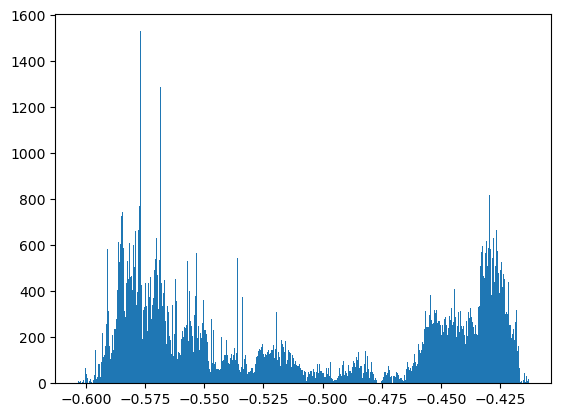

[-0.53834563 -0.53834788 -0.53834804 ... -0.45078736 -0.45490104
 -0.45489684]


In [61]:
path = "grad_data_2023.csv"
D = pd.read_csv(path)  

#D = df[['theo_event_tx_timestamp','under']] 

DAX_min = D[feature].min() # maximum value of the data
DAX_max = D[feature].max() # minimum value of the data
DAX_range = DAX_max - DAX_min   # data range

data = D[feature].to_numpy()  # convert data to numpy array
plt.hist(data,bins=600)  # plot the data as a histogram
plt.show()

print(data)

n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(2 / 7) * x_max, (5 / 7) * x_max]
sigmas = [x_max / 8] * 2

#data = mixture_gaussian_pdf(x_input, mus, sigmas)

In [62]:
# function to convert data in the interval (vmin-epsilon,vmax+epsilon) into bitstring using 12-bit precision
def data_to_bitstring(value,vmin,vmax,epsilon=0,precision=20):
    int_value = int((value - vmin + epsilon)/((vmax-vmin)+2*epsilon)*(2**precision-1))
    bitstring = format(int_value,'020b')
    return bitstring

# convert bitstring of length precision to a data point in the range (vmin-epsilon,vmax+epsilon)
def bitstring_to_data(bitstring,vmin,vmax,epsilon=0):
    precision = len(bitstring)
    bitstring = bitstring[::-1]
    vint = 0
    for j in range(precision):
        vint += int(bitstring[j])*(2**j)  # obtain integer representation from the bitstring
    value = vmin - epsilon + vint/(2**precision-1)*(vmax - vmin + 2*epsilon) # bring into the range (vmin-epsilon,vmax+epsilon)
    return value


#data = [data_to_bitstring(d,0,1) for d in data]

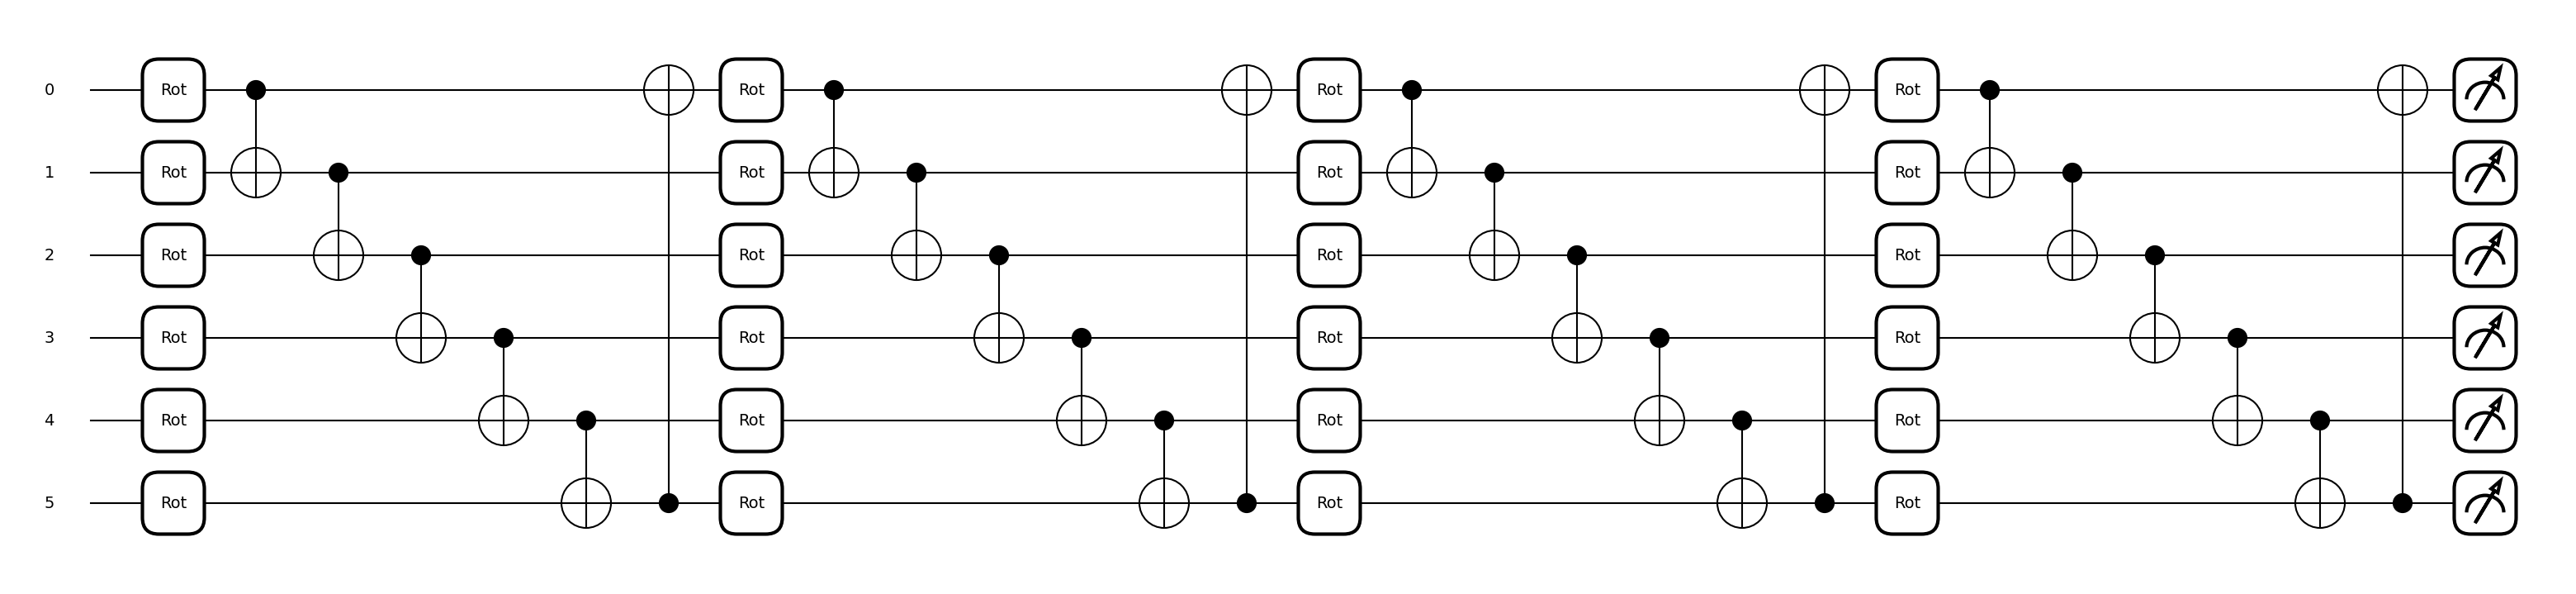

In [63]:
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 4
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)


@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(
        weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
    )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [64]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

TypeError: sub got incompatible shapes for broadcasting: (64,), (117845,).

TypeError: bar() missing 1 required positional argument: 'height'

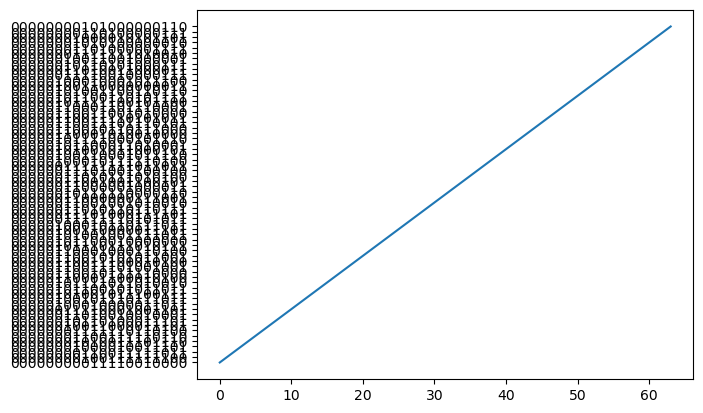

In [97]:
qcbm_probs = qcbm.circ(weights)

plt.plot(data)
plt.bar(qcbm_probs)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()